In [1]:
%matplotlib inline
from matplotlib import style
style.use('bmh')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, extract

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")



In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [16]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [20]:
session.query(Measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x22ea5b746c8>,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'date': '2010-01-01'}

# Exploratory Climate Analysis

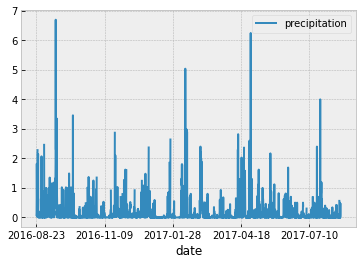

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
results = []
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

df = pd.DataFrame()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()

In [22]:
session.close

<bound method Session.close of <sqlalchemy.orm.session.Session object at 0x0000022EA5B65048>>

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [24]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [25]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

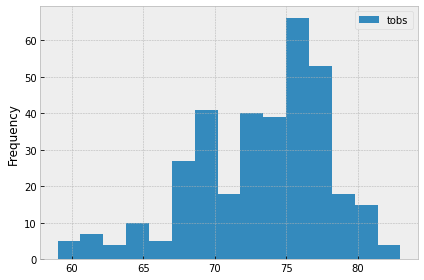

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=15)
plt.tight_layout()

In [55]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start, end):
    session = Session(engine)

    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]           

    if not end: 
        results = session.query(*sel).\
            filter(Measurement.date >= start).all()
        temps = list(np.ravel(results))
        return(temps)
    else:
        results = session.query(*sel).\
            filter(Measurement.date >= start).\
            filter(Measurement.date <= end).all()
        temps = list(np.ravel(results))
        return(temps)

    session.close()




In [56]:

start = "2016-05-01"
end = "2018-06-01"

calc_temps(start, end)


[58.0, 74.95860196810315, 87.0]

# Challenge

In [47]:
weather_June = pd.DataFrame(session.query(Measurement.tobs, Measurement.prcp).filter(extract('month', Measurement.date)==6).all())
weather_June.describe()

,tobs,prcp
count,1700.000000,1574.000000
mean,74.944118,0.136360
std,3.257417,0.335731
min,64.000000,0.000000
25%,73.000000,0.000000
50%,75.000000,0.020000
75%,77.000000,0.120000
max,85.000000,4.430000


In [52]:
weather_December = pd.DataFrame(session.query(Measurement.tobs, Measurement.prcp).filter(extract('month', Measurement.date)==12).all())
weather_December.describe()
        

,tobs,prcp
count,1517.000000,1405.000000
mean,71.041529,0.216819
std,3.745920,0.541399
min,56.000000,0.000000
25%,69.000000,0.000000
50%,71.000000,0.030000
75%,74.000000,0.150000
max,83.000000,6.420000


Analysis:
I analyzed all the data provided in the data set and included in the results for the month of June and December for all years available.  Based on the analysis, the biggest difference observed is in the maximimum precipitation.  In December it is observed that there was a recorded event that was 50% greater than June.  In addition, median temperature for December is 4 degrees cooler than in June.  

Ultimately, the concern about precipication differences between December and June is negligable with only a limited number of events where significantly more rain fell.  In addition, the minor differences in temperature supports the observation that there is negligable difference between June and December, providing support that this island is an excellent location for the surf/ice cream store.

Further Analysis:
It will be important to determine if the observations for June and December are not isolated information.  The next step would be to agregate all the months and evaluate them using a line graph evaluating both temperatures and precipitation to insure that the conditions are ideal all year round.

Another point of study would be to evaluate if the yearly weather has cycles from year to year.  It is possible that the temperatures and precipitation is increasing or decreasing as the years progress.  This will need to be studied.